In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pandas as pd
import os

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [2]:
r_df = pd.read_csv("dataset/train.csv")
df = r_df.drop("Unnamed: 0", axis = 1).sample(frac=1)
dummies = pd.get_dummies(df['label'])
new_df = pd.concat([df, dummies], axis = 1)
fraction = int(0.9 * len(df))
train_frac = int(0.9 * fraction)
train_df = new_df.iloc[:train_frac]
valid_df = new_df.iloc[train_frac:fraction]
test_df = new_df.iloc[fraction:]

In [3]:
test_df

,filename,label,directory,width,height,0,1,2,3,4,5,6,7,8,9
16260,img_38414.jpg,3,dataset/trainingSet/trainingSet/3/img_38414.jpg,28,28,0,0,0,1,0,0,0,0,0,0
8805,img_9909.jpg,1,dataset/trainingSet/trainingSet/1/img_9909.jpg,28,28,0,1,0,0,0,0,0,0,0,0
1345,img_22668.jpg,0,dataset/trainingSet/trainingSet/0/img_22668.jpg,28,28,1,0,0,0,0,0,0,0,0,0
27313,img_2910.jpg,6,dataset/trainingSet/trainingSet/6/img_2910.jpg,28,28,0,0,0,0,0,0,1,0,0,0
8317,img_5877.jpg,1,dataset/trainingSet/trainingSet/1/img_5877.jpg,28,28,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5051,img_16897.jpg,1,dataset/trainingSet/trainingSet/1/img_16897.jpg,28,28,0,1,0,0,0,0,0,0,0,0
10814,img_28110.jpg,2,dataset/trainingSet/trainingSet/2/img_28110.jpg,28,28,0,0,1,0,0,0,0,0,0,0
2207,img_30320.jpg,0,dataset/trainingSet/trainingSet/0/img_30320.jpg,28,28,1,0,0,0,0,0,0,0,0,0
1419,img_23443.jpg,0,dataset/trainingSet/trainingSet/0/img_23443.jpg,28,28,1,0,0,0,0,0,0,0,0,0


In [4]:
class multi_layer_conv:
    def __init__(self, train_df, valid_df, test_df, batch_size):
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.train_gen = self.train_gen = self.get_gen(self.train_df)
        self.valid_gen = self.get_gen(self.valid_df)
        self.test_gen = self.get_gen(self.test_df)
        self.model = Sequential()
        
        
        
    def get_gen(self, df):
        return ImageDataGenerator().flow_from_dataframe(
        dataframe = df,
        x_col = "directory",
        y_col = df.columns[5:],
        target_size = (28, 28),
        color_mode = "grayscale",
        class_mode = "raw",
        batch_size = self.batch_size,
        )
    
    def choose(self, item, learning_rate = 0.001):
        if item == "gradient":
            return tf.keras.optimizers.SGD(learning_rate = learning_rate)
        elif item == 'adam':
            return 'adam'
        elif item == 'binary_crossentropy':
            return 'binary_crossentropy'
        elif item == 'mean_squared_error':
            return tf.keras.losses.MeanSquaredError()

    def build_model(self, optimizer, loss, learning_rate = 0.001):
        self.model = Sequential([
            Conv2D(4, (5,5), padding = 'valid', input_shape = (28, 28, 1)),
            MaxPooling2D(),
            
            
            Conv2D(32, (3,3), padding = 'valid'),
            MaxPooling2D(),
            
            
            Flatten(),
            Dense(128, activation = 'relu'),
            Dense(64, activation = 'relu'),
    
            Dense(10, activation = 'softmax')
        ])
        
        self.model.summary()
        self.model.compile(optimizer = self.choose(optimizer, learning_rate),
                     loss = self.choose(loss),
                     metrics = [tf.keras.metrics.MeanSquaredError(), 'accuracy'])
        
    
    def train_model(self, epochs):
        ssTrain = self.train_gen.n//self.batch_size
        ssValid = self.valid_gen.n//self.batch_size
        history = self.model.fit(
            self.train_gen,
            epochs = epochs,
            steps_per_epoch = ssTrain,
            validation_steps = ssValid,
            validation_data = self.valid_gen
        )
        return history
    

In [5]:
model = multi_layer_conv(train_df, valid_df, test_df, 32)
model.build_model("adam", "binary_crossentropy", 0.00316)
history = model.train_model(1)



Found 34020 validated image filenames.
Found 3780 validated image filenames.
Found 4200 validated image filenames.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 4)         104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        1184      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
     

In [6]:
model.model.evaluate(model.test_gen)

132/132 [==============================] - 1s 8ms/step - loss: 0.0362 - mean_squared_error: 0.0078 - accuracy: 0.9510


[0.03616742789745331, 0.007778053171932697, 0.950952410697937]

In [5]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
temp = cv2.resize(frame, [28, 28])
gray_frame = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
gray_frame = np.asarray([gray_frame]).astype(np.float32)
model.model.predict(gray_frame)


array([[6.8869591e-01, 3.1995398e-05, 4.6151781e-05, 3.2321367e-02,
        2.8682729e-07, 1.0781480e-02, 2.1412798e-04, 1.4952126e-02,
        2.5256887e-01, 3.8762481e-04]], dtype=float32)

2


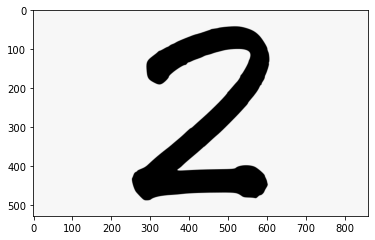

In [24]:
pic = cv2.imread(r"C:\Users\PC\OneDrive\Desktop\download.png")
plt.imshow(pic)
pic = cv2.resize(pic, [28, 28])
pic = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
pic = cv2.bitwise_not(pic)
(thresh, im_bw) = cv2.threshold(pic, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
thresh = 127
pic = cv2.threshold(pic, thresh, 255, cv2.THRESH_BINARY)[1]
pic = np.asarray([pic]).astype(np.float32)
print(np.argmax(model.model.predict(pic)))


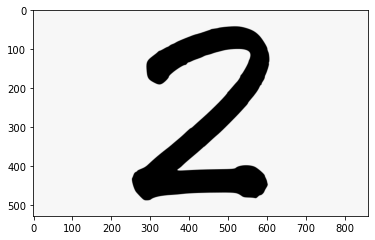

In [22]:
pic = cv2.imread(r"C:\Users\PC\OneDrive\Desktop\download.png")
plt.imshow(pic)
pic = cv2.resize(pic, [28, 28])
pic = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
pic = cv2.bitwise_not(pic)
(thresh, im_bw) = cv2.threshold(pic, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
thresh = 127
im_bw = cv2.threshold(pic, thresh, 255, cv2.THRESH_BINARY)[1]
#plt.imshow(im_bw)